$$ \space Weather \space Image\space Recognition $$

---




# Problem & Data Definition

## Problem Definition:
- Weather recognition is an important task in various fields such as agriculture, transportation, and disaster control. 
- The ability to accurately classify weather conditions from images can help in making  decisions and mitigating risks associated with weather related events. 
- The goal of the project is to develop a deep learning model that can accurately classify images into different types of weather conditions. This can be considered a multi-class classification problem, where each image belongs to one of the following weather categories: hail, rainbow, frost, rime, fog/smog, snow, rain, glaze, lightning, sandstorm, or dew.<br>

The Data set used can be found on Kaggel. [Click here](https://www.kaggle.com/datasets/jehanbhathena/weather-dataset/data)

## Importing Essential Libraries

In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img ,image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from keras.optimizers import Adam , SGD
from keras.models import Model, Sequential, load_model
from keras.layers import Dropout, BatchNormalization
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten,GlobalAveragePooling2D, Reshape
from keras.callbacks import EarlyStopping
from keras.applications import DenseNet121, DenseNet201
from keras.applications import EfficientNetB0, EfficientNetB4
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split


## Import Additional Libraries

In [6]:
import cv2
#from google.colab.patches import cv2_imshow
import warnings
warnings.filterwarnings("ignore", message="Passing `palette` without assigning `hue`")

# Set random seed for TensorFlow
tf.random.set_seed(42)

## Defining Functions
Here we will define any used function during the project.

In [ ]:

def read_images_from_dir(directory):
  """Read images from a directory and resize them to (244, 244).

    Args:
        directory (str): The path to the directory containing images.

    Returns:
        tuple: A tuple containing two NumPy arrays:
               - The first array contains the images, each resized to (244, 244).
               - The second array contains the corresponding labels.

  """

  images = []
  labels = []
  for label in os.listdir(directory):
      label_path = os.path.join(directory, label)
      if os.path.isdir(label_path):
          for filename in os.listdir(label_path):
              if filename.endswith('.jpg') :
                  image_path = os.path.join(label_path, filename)
                  image = cv2.imread(image_path)
                  #cv2_imshow(image)
                  #print(image_path)
                  image = cv2.resize(image, (244,244),)
                  images.append(image)
                  labels.append(label)
  return np.array(images), np.array(labels)



def save_images_to_dir(images, labels, directory):
    for i, (image, label) in enumerate(zip(images, labels)):
        label_directory = os.path.join(directory, label)
        if not os.path.exists(label_directory):
            os.makedirs(label_directory)
        filename = f"{i}_{label}.jpg"
        cv2.imwrite(os.path.join(label_directory, filename), image)





###########################################################################################

def augment_one_class(class_name, output_path="/content/AugmentedData" , val_split = 0.2,image_shape = (244,244,3)):

  """Augments images of a single class using Keras' ImageDataGenerator and moves them to an output directory.

  Args:
    class_name (str): The name of the class whose images are to be augmented.
    output_path (str, optional): The path where the augmented images will be saved. Defaults to "/content/AugmentedData".
    val_split (float, optional): The validation split ratio. Defaults to 0.2.
    image_shape (tuple, optional): The shape of the images (height, width, channels). Defaults to (244, 244, 3).

  Returns:
    None
  """
  class_dir = '/content/training_directory/' + class_name
  output_dir = class_dir + "/" + class_name.capitalize()


  os.makedirs(output_dir)
  os.system("mv " + class_dir +"/*.jpg " + output_dir)



  #Data = image_dataset_from_directory(class_dir)

  image_gen = ImageDataGenerator(rotation_range=20,   # rotate the image 20 degrees
                                width_shift_range=0.5,    # shift the image width by a max of 5%
                                height_shift_range=0.5,   # shift the image height by a max of 5%
                                shear_range=0.1,           # shear for cutting away part of the image(max 10%)
                                zoom_range=0.1,            # zoom in by 10% max
                                horizontal_flip=True,      # allow horizontal flipping
                                fill_mode='reflect', # fill in missing pixels with the nearest filled value
                                validation_split= val_split
                                 )


  val_image_gen = image_gen.flow_from_directory(class_dir,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=1,
                                                class_mode='categorical',
                                                subset = 'validation',
                                                shuffle=False,
                                                save_to_dir=output_dir,
                                                save_format='jpg',
                                                save_prefix='aug')

  i = 1
  for B in val_image_gen:
    i+= 1
    if i >= len(val_image_gen):
      break

  if not os.path.exists(output_path):
    os.makedirs(output_path)
  os.system("mv " + output_dir +" " + output_path)



## Importing Data
To import data to Google Colab you need to get your API token from your kaggel settengs page and add `kaggle.json` to your colab and run the following comands:


```
!mkdir /root/.kaggle
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d jehanbhathena/weather-dataset
!unzip /content/weather-dataset.zip
```
Now you can find a folder named `dataset` contains the data.


## Data Definition

In [10]:
path = "/content/dataset"
print(os.listdir(path))

['fogsmog', 'rime', 'snow', 'sandstorm', 'dew', 'lightning', 'glaze', 'hail', 'rainbow', 'frost', 'rain']


The dataset consists of 6,862 labeled images categorized into 11 folders, each representing a different weather condition. The folders and their respective file counts are as follows:

1.  `dew - 698 files`
2.  `fogsmog - 851 files`
3.  `frost - 475 files`
4.  `glaze - 639 files`
5.  `hail - 591 files`
6.  `lightning - 377 files`
7.  `rain - 526 files`
8.  `rainbow - 232 files`
9.  `rime - 1160 files`
10. `sandstorm - 692 files`
11. `snow - 621 files`


Each file within the folders contains an image corresponding to the respective weather condition. These images will serve as the input data for training, testing and evaluating the multi-class classification model.

In [12]:
Total = 0
images_count_dict = {}
for image_filename in os.listdir(path):

    folder_path = os.path.join(path, image_filename)
    images_count = len(os.listdir(folder_path))
    images_count_dict[image_filename] = images_count
    Total+= images_count
    print('{} folder has {} images'.format(image_filename ,  images_count))
print("\nTotal number of images:",Total)

fogsmog folder has 851 images
rime folder has 1160 images
snow folder has 621 images
sandstorm folder has 692 images
dew folder has 698 images
lightning folder has 377 images
glaze folder has 639 images
hail folder has 591 images
rainbow folder has 232 images
frost folder has 475 images
rain folder has 526 images

Total number of images: 6862


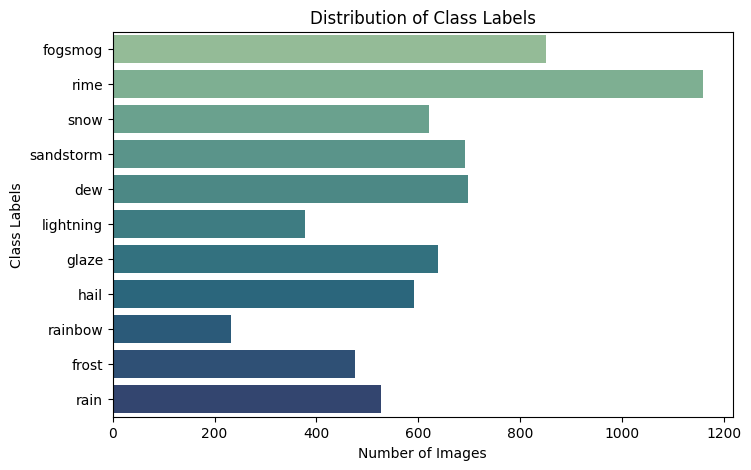

In [25]:
data = list(images_count_dict.items())

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(y=[x[0] for x in data], x=[x[1] for x in data],orient='horizontal',palette='crest',hue=[x[0] for x in data] ,legend=False )
plt.ylabel('Class Labels')
plt.xlabel('Number of Images')
plt.title('Distribution of Class Labels')
plt.show();

**Imbalanced data set, To solve this problem we will use data augmentation.**

**Let's find out the average dimensions of these images.**

In [ ]:
dim1 = []    # width
dim2 = []    # height
colors = []  # color channel

for i, image_filename in enumerate(os.listdir(path)):
    
    subfolders_path = os.path.join(path, image_filename)
    print(subfolders_path)
    
    for image_path in os.listdir(subfolders_path):
        
        image = imread(os.path.join(subfolders_path,image_path))

        # handling gray scale images if any
        if len(image.shape) < 3:
            image = image.reshape(image.shape+(1,))
            
        d1,d2,color = image.shape
        dim1.append(d1)
        dim2.append(d2)
        colors.append(color)

/kaggle/input/weather-dataset/dataset/hail
/kaggle/input/weather-dataset/dataset/rainbow
/kaggle/input/weather-dataset/dataset/frost
/kaggle/input/weather-dataset/dataset/rime
/kaggle/input/weather-dataset/dataset/fogsmog
/kaggle/input/weather-dataset/dataset/snow
/kaggle/input/weather-dataset/dataset/rain
/kaggle/input/weather-dataset/dataset/glaze
/kaggle/input/weather-dataset/dataset/lightning
/kaggle/input/weather-dataset/dataset/sandstorm
/kaggle/input/weather-dataset/dataset/dew


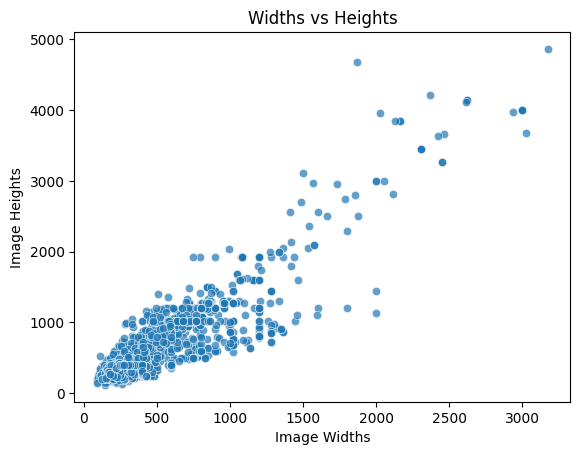

In [ ]:
# There is a wide variety of image dimensions in the dataset
sns.scatterplot(x=dim1, y=dim2, alpha = 0.7)
plt.xlabel('Image Widths')
plt.ylabel('Image Heights')
plt.title('Widths vs Heights');


- The image widths reach up to 3000.
- The image heights reach up to 5000.

In [ ]:
# mean of images width
np.mean(dim1)

373.8417371028855

In [ ]:
# mean of images height
np.mean(dim2)

520.0297289419995

In [ ]:
# number of color channels found
np.unique(colors)

array([1, 3, 4])

The number of color channels found in the images are 1, 3 and 4 :

- "1" : Indicates grayscale images, which have a single color channel.
- "3" : Represents RGB (Red, Green, Blue) images, where each pixel is represented by three color channels.
- "4" : Indicates RGBA (Red, Green, Blue, Alpha) images, which include an additional alpha channel for transparency or opacity information.


 - It's beneficial for the input images to have the same size when training a CNN. Therefore we could specify the input_shape to be (373,520,3).

## Splitting Dataset
Let's start by splitting our image data set into both training and testing data sets.<br>

`Note:` We will read images using OpenCV and split the dataset then we will resave the data to apply data augmentation to only the training dataset.<br>

`Note:` Both snow image `1187.jpg` and fogsmog `4514.jpg` were deleted because of an error due to they are `GIF` images.

In [28]:
# Load images and labels
images, labels = read_images_from_dir("/content/dataset")

# Split the dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42)


In [220]:
train_dir = "/content/training_directory"
test_dir = "/content/testing_directory"

# Save training dataset
save_images_to_dir(train_images, train_labels, train_dir)

# Save testing dataset
save_images_to_dir(test_images, test_labels, test_dir)

In [189]:
Total = 0
images_count_dict = {}

for image_filename in os.listdir("/content/training_directory"):

    folder_path = os.path.join("/content/training_directory", image_filename)
    images_count = len(os.listdir(folder_path))
    images_count_dict[image_filename] = images_count
    Total+= images_count
    print('{} folder has {} images'.format(image_filename ,  images_count))
print("\nTotal number of images:",Total)

fogsmog folder has 665 images
rime folder has 919 images
snow folder has 492 images
sandstorm folder has 562 images
dew folder has 564 images
lightning folder has 296 images
glaze folder has 524 images
hail folder has 477 images
rainbow folder has 179 images
frost folder has 388 images
rain folder has 422 images

Total number of images: 5488


## Data Augmantation

**Since we have an imbalanced dataset and relatively small dataset, we need to consider taking some steps, such as:**
- Data Augmentation
- Collecting more data
- Choosing appropriate evaluation metrics that are robust to class imbalances. 

### First Approach
Here we will apply data augmentation to only the training data sit with different ratios to minimize imbalance in our data.

- **Data Preprocessing**:<br>
 We've utilized data augmentation techniques to increase the number of data and balance it. By applying various transformations to the existing data, such as rotation, shifting, flipping, and zooming, data augmentation helped create additional training examples.
   
#### ImageDataGenerator Used Parameters:

- `rotation_range`: Random rotation applied to the images within 20 degrees.
- `width_shift_range`: Random horizontal shift applied to the images as a fraction of total width (10%).
- `height_shift_range`: Random vertical shift applied to the images as a fraction of total height (10%).
- `brightness_range`: Range for randomly adjusting brightness of the images from the range [0.5-1.5].
- `shear_range`: Random shear intensity applied to the images (15%).
- `zoom_range`: Range for randomly zooming into the images (20%).
- `horizontal_flip`: Randomly flips images horizontally.
- `fill_mode`: Strategy for filling in newly created pixels.
- `rescale`: Rescaling factor for pixel values normalization.

These parameters are applied to augment the training data and enhance the robustness and generalization of the model.


In [221]:
augment_one_class("rainbow", output_path="/content/AugmentedData" , val_split = 0.99,image_shape = (244,244,3))

Found 177 images belonging to 1 classes.


In [222]:
augment_one_class("frost", output_path="/content/AugmentedData" , val_split = 0.65,image_shape = (244,244,3))


Found 252 images belonging to 1 classes.


In [223]:
augment_one_class("rain", output_path="/content/AugmentedData" , val_split = 0.40,image_shape = (244,244,3))


Found 168 images belonging to 1 classes.


In [224]:
augment_one_class("hail", output_path="/content/AugmentedData" , val_split = 0.35,image_shape = (244,244,3))
augment_one_class("glaze", output_path="/content/AugmentedData" , val_split = 0.30,image_shape = (244,244,3))
augment_one_class("lightning", output_path="/content/AugmentedData" , val_split = 0.85,image_shape = (244,244,3))
augment_one_class("dew", output_path="/content/AugmentedData" , val_split = 0.15,image_shape = (244,244,3))


Found 166 images belonging to 1 classes.
Found 157 images belonging to 1 classes.
Found 251 images belonging to 1 classes.
Found 84 images belonging to 1 classes.


In [225]:
augment_one_class("sandstorm", output_path="/content/AugmentedData" , val_split = 0.30,image_shape = (244,244,3))
augment_one_class("snow", output_path="/content/AugmentedData" , val_split = 0.45,image_shape = (244,244,3))
augment_one_class("rime", output_path="/content/AugmentedData" , val_split = 0.01,image_shape = (244,244,3))
augment_one_class("fogsmog", output_path="/content/AugmentedData" , val_split = 0.20,image_shape = (244,244,3))


Found 168 images belonging to 1 classes.
Found 221 images belonging to 1 classes.
Found 9 images belonging to 1 classes.
Found 133 images belonging to 1 classes.


In [226]:
Total = 0
images_count_dict = {}

for image_filename in os.listdir("/content/AugmentedData"):

    folder_path = os.path.join("/content/AugmentedData", image_filename)
    images_count = len(os.listdir(folder_path))
    images_count_dict[image_filename] = images_count
    Total+= images_count
    print('{} folder has {} images'.format(image_filename ,  images_count))
print("\nTotal number of images:",Total)

Glaze folder has 680 images
Rainbow folder has 355 images
Snow folder has 712 images
Sandstorm folder has 729 images
Frost folder has 639 images
Lightning folder has 546 images
Hail folder has 642 images
Dew folder has 647 images
Fogsmog folder has 797 images
Rime folder has 927 images
Rain folder has 589 images

Total number of images: 7263


Training data increases from `5488` to `7263` means a `32 % ` increase.

Let's save the new data to our drive so we don't have to rerun the whole notebook again.


```
!cp -r /content/AugmentedData /content/drive/MyDrive/DeepLearningData
!cp -r /content/testing_directory /content/drive/MyDrive/DeepLearningData

```
This is the Augmented data link, and any one with the link can download/access data.  [From Here](https://drive.google.com/drive/folders/1lWBd46jv6VSd7rWXN_GEopBsxov63d3v?usp=sharing)



In [4]:
# path at Google colab
Training_path = '/content/drive/MyDrive/DeepLearningData/AugmentedData'
Testing_path = "/content/drive/MyDrive/DeepLearningData/testing_directory"

In [ ]:
# paths to new dataset at kaggel
train_path = '/kaggle/input/new-weather-ds/new dataset/train'
test_path = '/kaggle/input/new-weather-ds/new dataset/test'

### Second Approach



- **Data collection**: <br> 
We have collected more data from another datasets, such as, [multi-class-weather-dataset](https://www.kaggle.com/datasets/vijaygiitk/multiclass-weather-dataset/data).



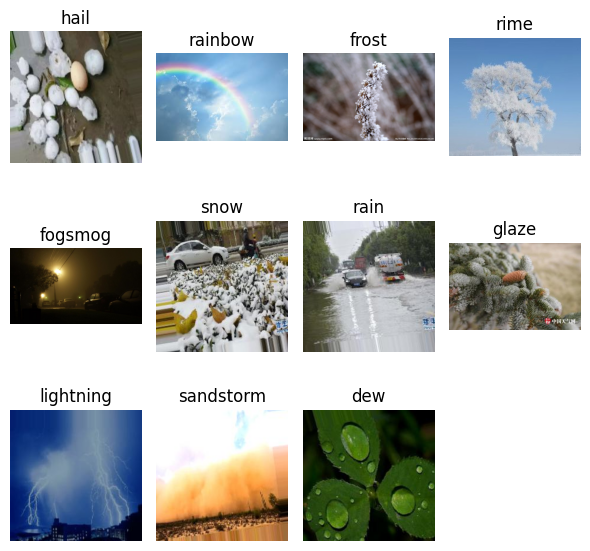

In [ ]:
fig = plt.figure(figsize=(6,6)) 
rows = 3
columns = 4


for i, image_filename in enumerate(os.listdir(train_path)):

    first_img_path = os.listdir(os.path.join(train_path, image_filename))[0]
    first_image = imread(os.path.join(train_path, image_filename, first_img_path))
    fig.add_subplot(rows, columns, i+1) 
    plt.axis('off') 
    plt.imshow(first_image)
    plt.title('{}'.format(image_filename, fontsize=10))

plt.tight_layout()
plt.show()

In [ ]:
all_data_sum=0
images_count_dict = {}
for image_filename in os.listdir(train_path):

    folder_path = os.path.join(train_path, image_filename)
    images_count = len(os.listdir(folder_path))
    images_count_dict[image_filename] = images_count
    all_data_sum+= images_count
    print('{} folder has {} images'.format(image_filename ,  images_count))

print("\nTotal Number of Images: {} image".format(all_data_sum))


hail folder has 960 images
rainbow folder has 974 images
frost folder has 1082 images
rime folder has 1020 images
fogsmog folder has 1008 images
snow folder has 1008 images
rain folder has 1093 images
glaze folder has 1024 images
lightning folder has 1007 images
sandstorm folder has 1020 images
dew folder has 1033 images

Total Number of Images: 11229 image


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


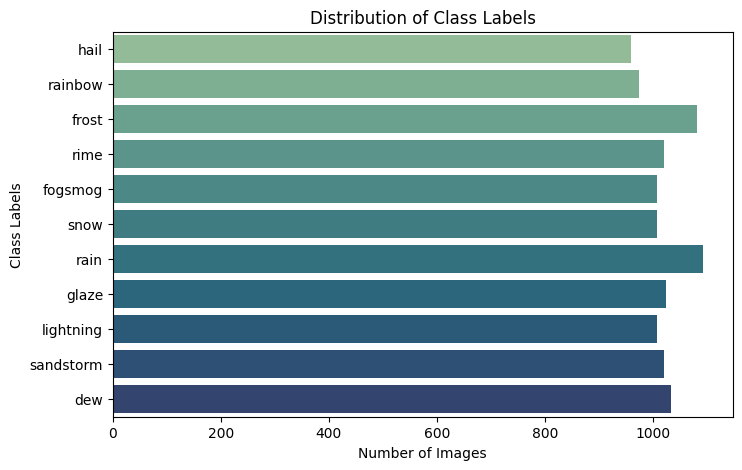

In [ ]:
data = list(images_count_dict.items())

# Create a bar plot using Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(y=[x[0] for x in data], x=[x[1] for x in data], palette='crest',orient='horizontal')
plt.ylabel('Class Labels')
plt.xlabel('Number of Images')
plt.title('Distribution of Class Labels');

### As we can observe from the plot, the data is much more balanced now compared to the original dataset. Also, we have doubled the size of the dataset

# Data Preprocessing

## Preparing the Data for the model

- We've split the data into `80% for training` and `20% for testing`. 
- Augmentation techniques have been applied to certain images within the training dataset.
- Since we've already augmented the dataset and saved the augmented images to disk, therefore we are now using an ImageDataGenerator to load the augmented images during training only.
- we also applied downsampling to the rime class to achieve data balance.

**Hyperparamters**

In [ ]:
image_shape = (224,224,3)
batch_size = 64
epochs = 100
no_classes = 11

In [ ]:
train_image_gen = ImageDataGenerator(rescale=1/255,            # rescale the image by normalzing it
                                    validation_split=0.2)      # split the data into 80% validation , 20% testing

test_image_gen = ImageDataGenerator(rescale=1/255)             # rescale the image by normalzing it
                                 

In [ ]:
# Defining training dataset
train_image_ds = train_image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               subset = 'training')

Found 8988 images belonging to 11 classes.


In [ ]:
# Defining validation dataset
val_image_ds = train_image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               subset = 'validation')

Found 2241 images belonging to 11 classes.


In [ ]:
# Defining testing dataset
test_image_ds = test_image_gen.flow_from_directory(test_path,
                                                  target_size=image_shape[:2],
                                                  color_mode='rgb',
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)  # Do not shuffle to keep the order consistent

Found 1427 images belonging to 11 classes.


In [ ]:
images, one_hot_labels = next(train_image_ds)
# get the 'one' which is corresponding to target label
labels = np.argmax(one_hot_labels, axis=1)

In [12]:
# ImageNet architectures excpect the image shapes to be 224 x 224
image_shape = (224,224,3)

In [21]:
Training_Data = image_dataset_from_directory(Training_path, image_size=(224, 224),label_mode='categorical')
Testing_Data = image_dataset_from_directory(Testing_path, image_size=(224, 224),label_mode='categorical')

Found 7263 files belonging to 11 classes.
Found 1372 files belonging to 11 classes.


##  Displaying sample of Augmented Data

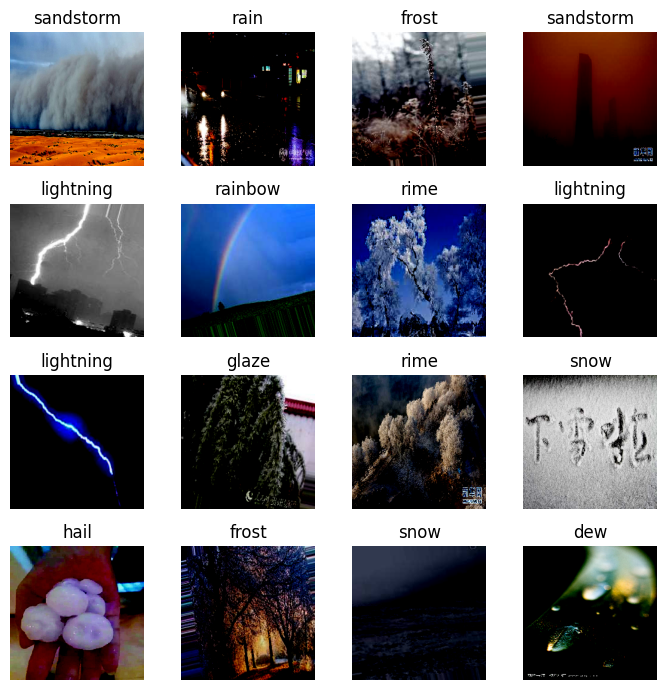

In [ ]:
# invert the dictionary using dict comprehension
label_names = {value: key for key, value in train_image_ds.class_indices.items()}

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(7,7))
ax = ax.flatten()

for i in range(16):
    ax[i].imshow(images[i])
    ax[i].set_title('{}'.format(label_names[labels[i]]))
    ax[i].axis('off')
plt.tight_layout()
plt.show()

### Scaling Data

# Training

## CNN

In [ ]:
model_CNN6 = Sequential()
model_CNN6.add(Conv2D(30,(4,4),input_shape=(224, 224, 3),activation="relu"))
model_CNN6.add(MaxPooling2D(pool_size = (2,2)))
model_CNN6.add(Conv2D(20, (3, 3), activation="relu"))
model_CNN6.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN6.add(Flatten())
model_CNN6.add(Dense(128, activation ="relu"))
model_CNN6.add(Dense(60, activation ="relu"))
model_CNN6.add(Dense(30, activation ="relu"))
model_CNN6.add(Dense(20, activation ="relu"))
model_CNN6.add(Dense(11, activation ="softmax"))
model_CNN6.compile(loss ="categorical_crossentropy", optimizer ="SGD", metrics =["accuracy"])
model_CNN6.summary()
early_stop = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True )
history4 = model_CNN6.fit(Training_Data, epochs = 100, verbose=1,validation_data=Testing_Data,callbacks=[early_stop])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 221, 221, 30)      1470      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 110, 110, 30)      0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 108, 108, 20)      5420      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 54, 54, 20)        0         
 ng2D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 58320)             0         
                                                                 
 dense_30 (Dense)            (None, 128)             

Poor Model, Let's try something else

## Transfer Learning
### Why use pre-trained model for Image Classification tasks?

Transfer learning is useful for image classification tasks due to several reasons:

- **Feature Extraction**: as our dataset is not considered a large one, a pre-trained convolutional neural networks (CNNs), such as those trained on ImageNet, have learned to extract rich and complex features from images.By leveraging these pre-trained models as feature extractors, transfer learning allows us to benefit from the representations learned by the CNNs on a diverse dataset. This can significantly improve the performance of image classification models, especially when working with limited labeled data.

- **Domain Adaptation**: Image classification tasks often involve diverse datasets with variations in image quality, lighting conditions, viewpoints, and object appearances. Pre-trained models have learned to capture generic features that are transferable across different domains.By fine-tuning a pre-trained model on a target dataset, transfer learning helps adapt the learned representations to the specific characteristics of the target dataset, improving classification accuracy.

- **Faster Convergence Time**: Training deep CNNs from scratch on large-scale image datasets can be computationally intensive and time-consuming. Transfer learning allows us to initialize the model with pre-trained weights, which serve as a good starting point for optimization. This often leads to faster convergence during training and shorter training times compared to training from scratch.

- **Mitigate the risk of Overfitting**: Pre-trained models act as effective regularizers by providing strong priors on the model's parameters. Fine-tuning a pre-trained model on a target dataset helps prevent overfitting, especially when the target dataset is small. Transfer learning encourages the model to learn task-specific features while retaining the generalization capabilities acquired from the source dataset.

## 1. DenseNet Architecture

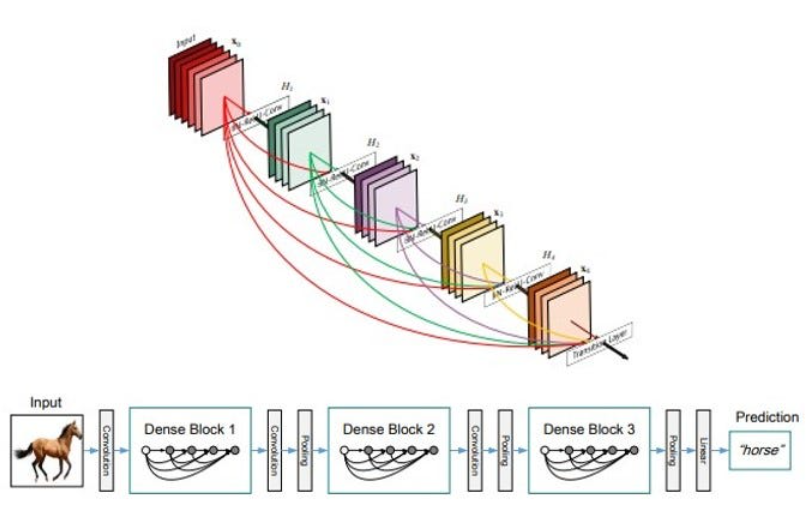

DenseNet-121 is a variant of the DenseNet architecture, designed to balance model depth and computational efficiency. DenseNet-121 is characterized by its **121-layer deep network with densely connected convolutional layers**.

### Key Features of DenseNet-121:

- **Dense Connectivity**: DenseNet-121 employs dense connectivity between layers, where each layer is connected to every other layer in a feed-forward fashion. This dense connectivity promotes feature reuse and facilitates information flow throughout the network, leading to more effective feature extraction.

- **Bottleneck Layers**: Similar to other DenseNet variants, DenseNet-121 utilizes bottleneck layers to reduce computational complexity and memory footprint. Bottleneck layers consist of 1x1 convolutional layers followed by 3x3 convolutional layers, aiding in dimensionality reduction and feature extraction.

- **Growth Rate**: DenseNet-121 maintains a growth rate parameter, which controls the number of feature maps produced by each layer in the network. This parameter influences the model's capacity to learn and adapt to complex patterns in the data.


- **Steps**
1. Load the ImageNet weights.

2. Include the top layers of a pre-trained model but exclude the final softmax layer, by setting include_top=True and then remove the final layer manually. so it allows us to use the pre-trained convolutional base and intermediate fully connected layers while customizing the final output layer according to our specific task.

3. Removing the final layer of the ImageNet task.

4. Iterate through all the layers in dense_model using a for loop. For each layer, we set the trainable attribute to False, effectively freezing the layer's weights during training.

5. Adding our custom layer (11 classes)


In [ ]:
# Load pre-trained DenseNet model 
dense_model = DenseNet121(weights='imagenet',
                          include_top=True,
                          input_shape = image_shape)

# Remove the final layer (softmax)
dense_model = Model(inputs=dense_model.input, outputs=dense_model.layers[-2].output)

# Freeze Layers
for layer in dense_model.layers:
    layer.trainable = False
    
# Adding a dropout layer
dropout_layer = Dropout(0.25)(dense_model.output)

# Adding our custom layer for our specific task
output = Dense(no_classes, activation='softmax')(dropout_layer)

# Define our model with the modified output layer
model = Model(inputs=dense_model.input, outputs=output)

# model.summary()

33188688/33188688 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True )

In [ ]:
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_image_ds,
                    epochs=epochs,
                    validation_data=val_image_ds,
                    callbacks=[early_stop])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/141 ━━━━━━━━━━━━━━━━━━━━ 19s 139ms/step - accuracy: 0.8906 - loss: 0.3244  

W0000 00:00:1713656868.450002     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8687 - loss: 0.3706

W0000 00:00:1713656928.615367     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/141 ━━━━━━━━━━━━━━━━━━━━ 117s 564ms/step - accuracy: 0.8687 - loss: 0.3707 - val_accuracy: 0.8791 - val_loss: 0.3367
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.8707 - loss: 0.3638 - val_accuracy: 0.8791 - val_loss: 0.3465
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 289ms/step - accuracy: 0.8685 - loss: 0.3693 - val_accuracy: 0.8853 - val_loss: 0.3387
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 289ms/step - accuracy: 0.8718 - loss: 0.3511 - val_accuracy: 0.8844 - val_loss: 0.3359
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - accuracy: 0.8784 - loss: 0.3408 - val_accuracy: 0.8795 - val_loss: 0.3487
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 283ms/step - accuracy: 0.8756 - loss: 0.3330 - val_accuracy: 0.8831 - val_loss: 0.3219
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 295ms/step - accuracy: 0.8792 - loss: 0.3441 - val_accuracy: 0.8826 - val_loss: 0.3482
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.8761 - loss: 0.34

# Model Evaluation

In [ ]:
# Loss and Accuracy on validation data
model.evaluate(val_image_ds)

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.8944 - loss: 0.3012


[0.29816538095474243, 0.8951361179351807]

In [ ]:
# Loss and Accuracy on test data (new unseen data)
model.evaluate(test_image_ds)

23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8807 - loss: 0.4088 


[0.44073155522346497, 0.8647512197494507]

In [ ]:
# Generate predictions using the trained model on the test dataset.
predictions_prob = model.predict(test_image_ds)

 2/23 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step 

W0000 00:00:1713658044.903921     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step 


In [ ]:
# Select the class with the highest probability as the predicted class
predictions = np.argmax(predictions_prob, axis=1)

In [ ]:
print(classification_report(test_image_ds.classes,predictions))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       136
           1       0.87      0.94      0.90       204
           2       0.76      0.76      0.76        91
           3       0.78      0.61      0.69       127
           4       0.95      0.95      0.95       110
           5       0.97      0.93      0.95        75
           6       0.91      0.83      0.87       154
           7       1.00      0.99      0.99        68
           8       0.83      0.90      0.86       229
           9       0.90      0.86      0.88       116
          10       0.72      0.79      0.75       117

    accuracy                           0.86      1427
   macro avg       0.87      0.86      0.87      1427
weighted avg       0.87      0.86      0.86      1427



- According to classification report, the model's average precision for all classes is approximately 87%, meaning that 87% of the predictions it classified for each class are accurate.
- The model can accurately identify about 86% of all cases that belong to each class, according to the average recall of 86% across all classes.
- All classes combined have an average F1-score of 87%, which denotes good overall performance.
- For the accuracy of 0.86 , the model is able to accurately predict the class label for almost 86% of the data.
- Macro average treats all classes equally,while weighted average accounts for class imbalance by weighting each class's score by its count(support). In this report, both macro and weighted averages have similar values, indicating balanced performance across classes.

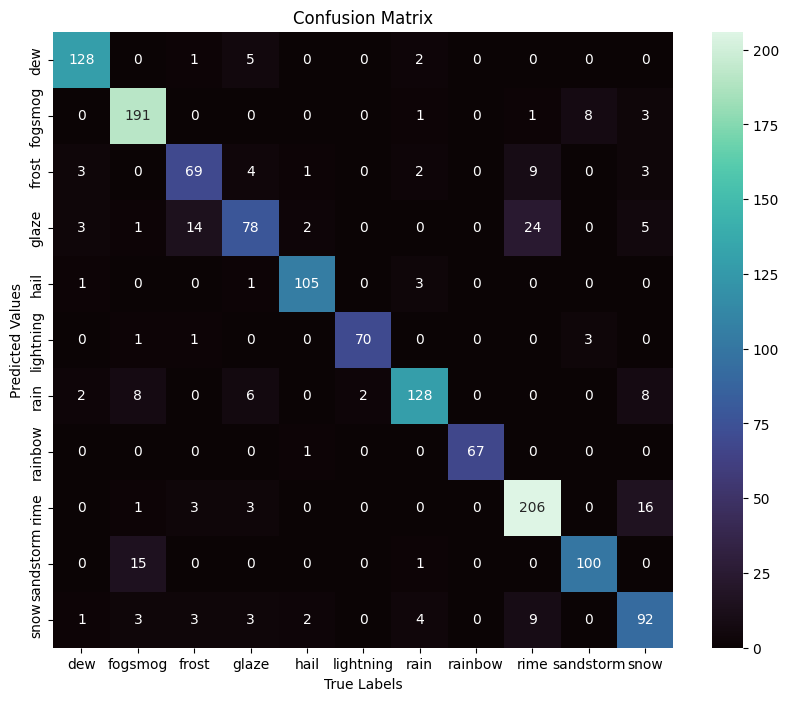

In [ ]:
plt.figure(figsize=(10,8))
cm = confusion_matrix(test_image_ds.classes,predictions)
ax = sns.heatmap(cm,annot=True,fmt='d',cmap='mako')
ax.set_xticklabels(test_image_ds.class_indices.keys())
ax.set_yticklabels(test_image_ds.class_indices.keys())

plt.xlabel('True Labels')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix');

# Result Visualization

In [ ]:
metrics = pd.DataFrame(history.history)

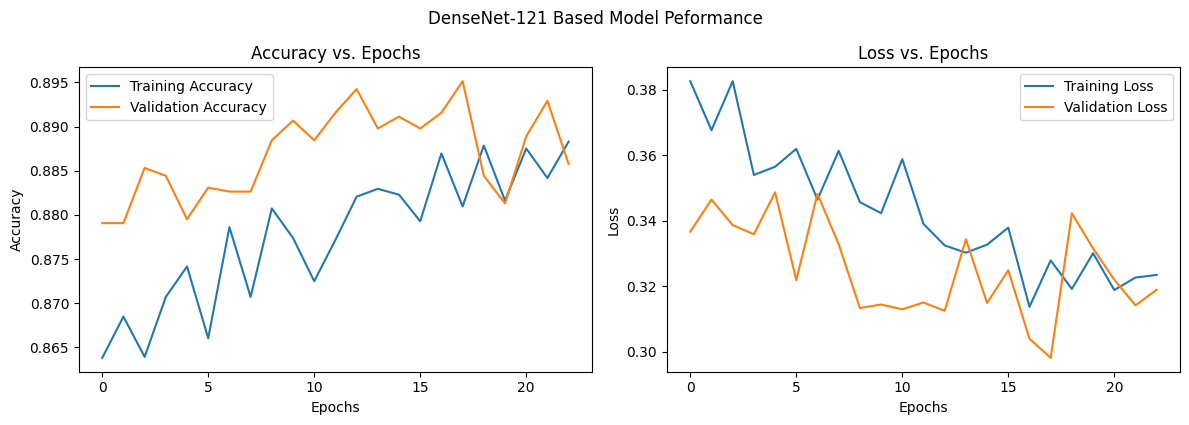

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(metrics['accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss vs. Epochs")
plt.legend()
plt.tight_layout()
plt.suptitle('DenseNet-121 Based Model Peformance', y = 1.05)
plt.show()

In [ ]:
#Save the model
model.save('densenet-121.h5')

# Result Visualization

In [ ]:
metrics = pd.DataFrame(history.history)

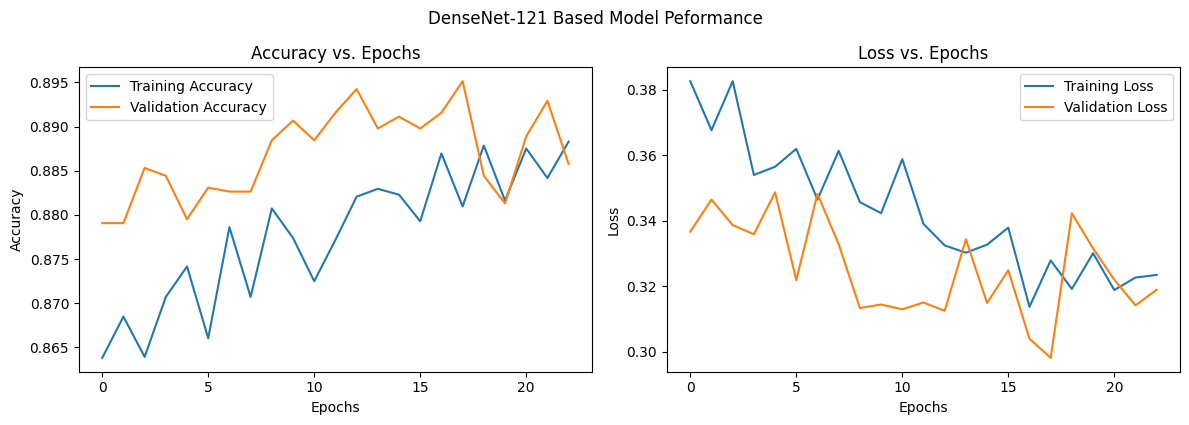

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(metrics['accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss vs. Epochs")
plt.legend()
plt.tight_layout()
plt.suptitle('DenseNet-121 Based Model Peformance', y = 1.05)
plt.show()

In [ ]:
#Save the model
model.save('densenet-121.h5')

# Model Evaluation

In [ ]:
# Loss and Accuracy on validation data
model.evaluate(val_image_ds)

36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 265ms/step - accuracy: 0.8939 - loss: 0.2898


[0.2886253297328949, 0.9009370803833008]

In [ ]:
# Loss and Accuracy on test data (new unseen data)
model.evaluate(test_image_ds)

23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 761ms/step - accuracy: 0.8929 - loss: 0.3673


[0.42249560356140137, 0.868255078792572]

In [ ]:
# Generate predictions using the trained model on the test dataset.
predictions_prob = model.predict(test_image_ds)

 2/23 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step 

W0000 00:00:1713670317.692721     135 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 965ms/step


In [ ]:
# Select the class with the highest probability as the predicted class
predictions = np.argmax(predictions_prob, axis=1)

In [ ]:
print(classification_report(test_image_ds.classes,predictions))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       136
           1       0.85      0.97      0.90       204
           2       0.76      0.77      0.77        91
           3       0.74      0.66      0.70       127
           4       0.94      0.94      0.94       110
           5       0.97      0.96      0.97        75
           6       0.91      0.84      0.87       154
           7       1.00      1.00      1.00        68
           8       0.81      0.90      0.86       229
           9       0.94      0.85      0.90       116
          10       0.79      0.70      0.74       117

    accuracy                           0.87      1427
   macro avg       0.88      0.87      0.87      1427
weighted avg       0.87      0.87      0.87      1427



- According to classification report, the model achieved slightly better performance than **Densenet-121** with average precision for all classes is approximately 88%, meaning that 88% of the predictions it generated for each class are accurate.
- The model can accurately identify about 87% of all cases that belong to each class, according to the average recall of 86% across all classes.
- All classes combined have an average F1-score of 87%, which denotes good overall performance.
- With accuracy of 87%, the model is able to accurately predict the class label for almost 87% of the data.
- Macro average treats all classes equally,while weighted average accounts for class imbalance by weighting each class's score by its count(support). In this report, both macro and weighted averages have similar values, indicating balanced performance across classes.

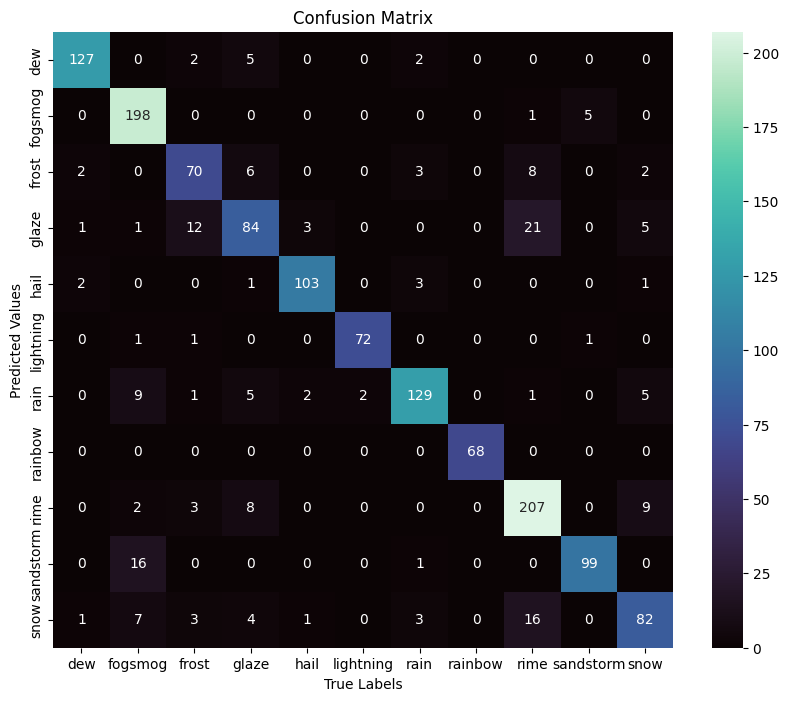

In [ ]:
plt.figure(figsize=(10,8))
cm = confusion_matrix(test_image_ds.classes,predictions)
ax = sns.heatmap(cm,annot=True,fmt='d',cmap='mako')
ax.set_xticklabels(test_image_ds.class_indices.keys())
ax.set_yticklabels(test_image_ds.class_indices.keys())

plt.xlabel('True Labels')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix');

# Result Visualization

In [ ]:
metrics = pd.DataFrame(history.history)

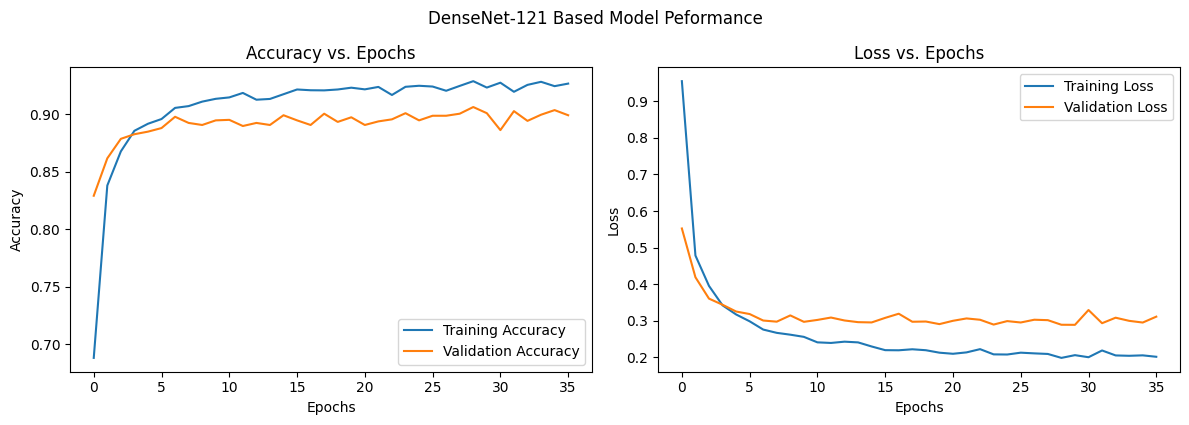

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(metrics['accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss vs. Epochs")
plt.legend()
plt.tight_layout()
plt.suptitle('DenseNet-121 Based Model Peformance', y = 1.05)
plt.show()

In [ ]:
#Save the model
model.save('densenet-201.h5')

# Squeeze and Excitation Networks

- Squeeze and Excitation Networks is an approach used to add some attention mechanism to an already existing CNN architecture for further improvements.
- Squeeze and Excitation Network (SENet) is one such attention mechanism that is most widely used for performance improvements.

## What is Squeeze and Excitation Network?
The squeeze and excitation attention mechanism was introduced in the year 2018 by Hu et al. in their paper [“Squeeze-and-Excitation Networks” ](https://arxiv.org/abs/1709.01507) at CVPR 2018 with a journal version in TPAMI. It is one of the most dominant paper in the field of attention mechanism and was cited more than 8000 times. 

## The intuition behind SENet
The convolution operator generates a feature map with the different number of channels, where it treats all the channels equally. It means that every single channel is equally important and this may not be the best way. The Squeeze and Excitation attention mechanism adds a parameter to each channel that rescales them independently.

## The architecture of Squeeze and Excitation Networks
- The SE-block consists of three operations:

1. Squeeze
2. Excitation
3. Scaling


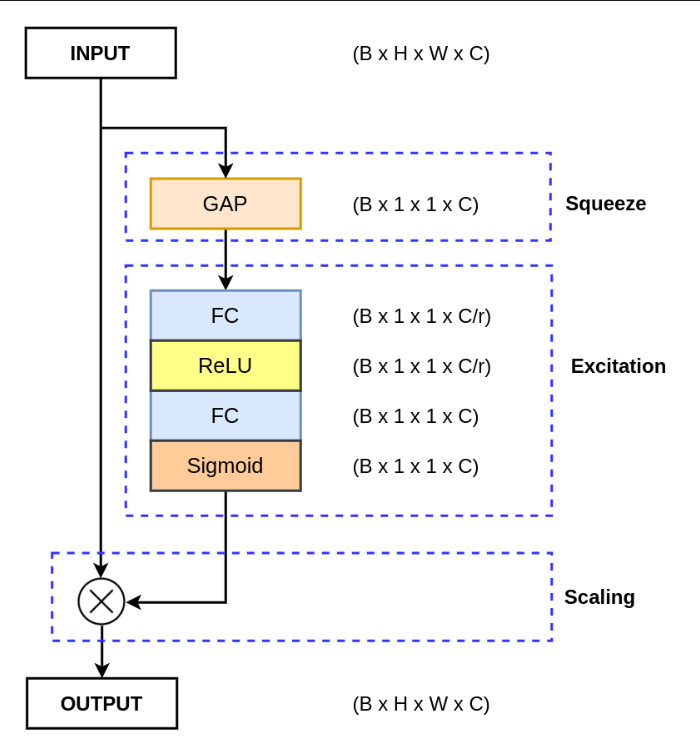


**source:** [Squeeze and Excitation Networks](https://idiotdeveloper.com/squeeze-and-excitation-networks/)


- We are going to modify the code to add SE blocks.
- After obtaining the feature maps from the DenseNet model, we pass them through SE blocks to perform channel-wise recalibration. 
- This step involves applying global pooling, fully connected layers, and element-wise multiplication with the original feature maps.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience = 7, restore_best_weights=True )

In [ ]:
# Load pre-trained DenseNet model 
base_model = DenseNet201(weights='imagenet',
                            include_top=False,
                            input_shape = image_shape)

# base_model.summary()


# Freeze layers
for layer in base_model.layers:
    layer.trainable = False
    
# Extract feature maps from the 'pool4_pool' (the output of averagepooling2d)
feature_maps = base_model.get_layer('pool4_pool').output

def SqueezeAndExcitation(inputs, reduction_ratio=8):
    num_channels = int(inputs.shape[-1])
    # Squeeze
    x = GlobalAveragePooling2D()(inputs)
    
    # Excitation
    x = Dense(num_channels // reduction_ratio, activation="relu", use_bias=False)(x)
    x = Dense(num_channels, activation="sigmoid", use_bias=False)(x)
    
    # Reshape for compatibility with inputs
    x = Reshape((1,1, num_channels))(x)
    
    # Scaling
    x = inputs * x
    return x

# Output feature maps modulated based on its importances
se_output = SqueezeAndExcitation(feature_maps)

# Adding flatten layer
flatten = Flatten()(se_output)

# Adding batch normalization
d_layer = Dense(128,kernel_regularizer=L1L2(l1=1e-5,l2=1e-5))(flatten)
# Adding batch normalization
batch_norm_layer = BatchNormalization()(d_layer)
activation_layer = Activation('relu')(batch_norm_layer)
# Adding a dropout layer
dropout_layer = Dropout(0.5)(activation_layer)
# Adding our custom layer for our specific task
output = Dense(no_classes, activation='softmax')(dropout_layer)


# Define our model with the modified output layer
model_1 = Model(inputs=base_model.input, outputs=output)

# model.summary()

In [ ]:
# Compile the model
model_1.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model_1.fit(train_image_ds,
                    epochs=epochs,
                    validation_data=val_image_ds,
                    callbacks=[early_stop])

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 96s 485ms/step - accuracy: 0.7294 - loss: 1.2309 - val_accuracy: 0.8902 - val_loss: 0.8555
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - accuracy: 0.9431 - loss: 0.6310 - val_accuracy: 0.9076 - val_loss: 0.6821
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 285ms/step - accuracy: 0.9722 - loss: 0.5031 - val_accuracy: 0.8983 - val_loss: 0.6737
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 276ms/step - accuracy: 0.9784 - loss: 0.4567 - val_accuracy: 0.9018 - val_loss: 0.6612
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 284ms/step - accuracy: 0.9806 - loss: 0.4287 - val_accuracy: 0.8911 - val_loss: 0.7132
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 291ms/step - accuracy: 0.9774 - loss: 0.4281 - val_accuracy: 0.9076 - val_loss: 0.6368
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 301ms/step - accuracy: 0.9835 - loss: 0.4021 - val_accuracy: 0.8777 - val_loss: 0.7579
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 301ms/step - accuracy: 0.9863 -

# Model Evaluation

In [ ]:
# Loss and Accuracy on validation data
model_1.evaluate(val_image_ds)

36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.9124 - loss: 0.5989


[0.6143207550048828, 0.9147701859474182]

In [ ]:
# Loss and Accuracy on test data (new unseen data)
model_1.evaluate(test_image_ds)

23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 687ms/step - accuracy: 0.9149 - loss: 0.6685


[0.7079265117645264, 0.8997897505760193]

**Squeeze & Excitaion blocks has improved Validation & Testing accuracy.**

In [ ]:
# Generate predictions using the trained model on the test dataset.
predictions_prob = model_1.predict(test_image_ds)

23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 840ms/step


In [ ]:
# Select the class with the highest probability as the predicted class
predictions = np.argmax(predictions_prob, axis=1)

In [ ]:
print(classification_report(test_image_ds.classes,predictions))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       136
           1       0.91      1.00      0.96       204
           2       0.82      0.77      0.80        91
           3       0.84      0.69      0.76       127
           4       0.99      0.95      0.97       110
           5       0.99      0.99      0.99        75
           6       0.85      0.87      0.86       154
           7       0.99      1.00      0.99        68
           8       0.86      0.92      0.89       229
           9       0.97      0.91      0.94       116
          10       0.79      0.84      0.81       117

    accuracy                           0.90      1427
   macro avg       0.91      0.90      0.90      1427
weighted avg       0.90      0.90      0.90      1427



### Comparison between the results of DenseNet-201 and DenseNet-201 with Squeeze-and-Excitation (SE) blocks:
- **Overall Accuracy:**
    - DenseNet-201: 87%
    - DenseNet-201 with SE blocks: 90%
    - The DenseNet-201 with SE blocks outperforms DenseNet-201 in terms of overall accuracy.
- **Precision, Recall, and F1-Score:**
   - For most classes, DenseNet-201 with SE blocks achieves higher precision, recall, and F1-score compared to DenseNet-201.
   - Improvements are observed in classes 0, 1, 4, 5, 6, 7, 8, 9, and 10 in terms of precision, recall, and F1-score.
   - Class 2 shows similar precision and recall but a slightly lower F1-score in the DenseNet with SE blocks model compared to DenseNet-201.
   - Class 3 shows slightly lower performance in terms of precision, recall, and F1-score in the DenseNet with SE blocks model compared to DenseNet-201.

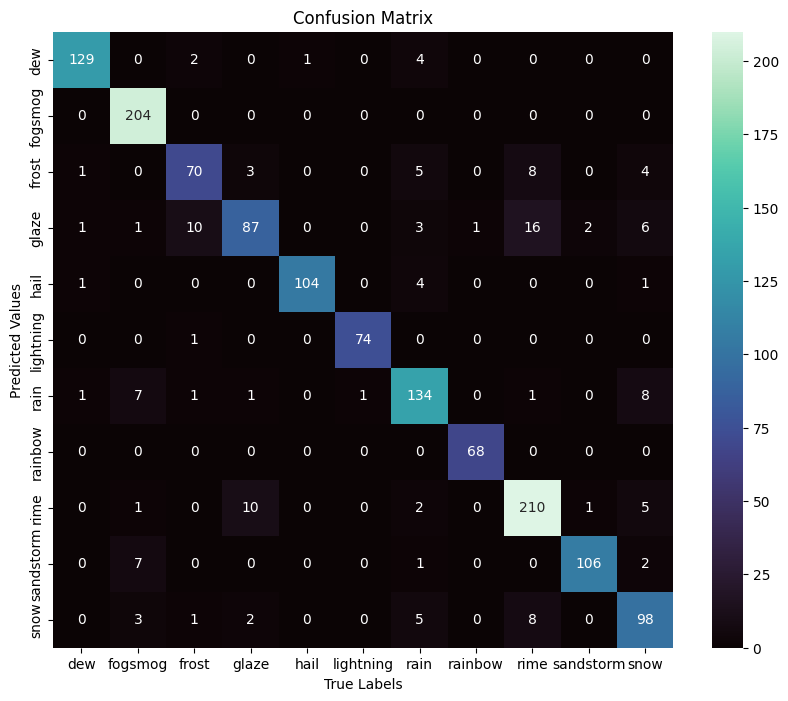

In [ ]:
plt.figure(figsize=(10,8))
cm = confusion_matrix(test_image_ds.classes,predictions)
ax = sns.heatmap(cm,annot=True,fmt='d',cmap='mako')
ax.set_xticklabels(test_image_ds.class_indices.keys())
ax.set_yticklabels(test_image_ds.class_indices.keys())

plt.xlabel('True Labels')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix');

# Result Visualization

In [ ]:
metrics = pd.DataFrame(history.history)

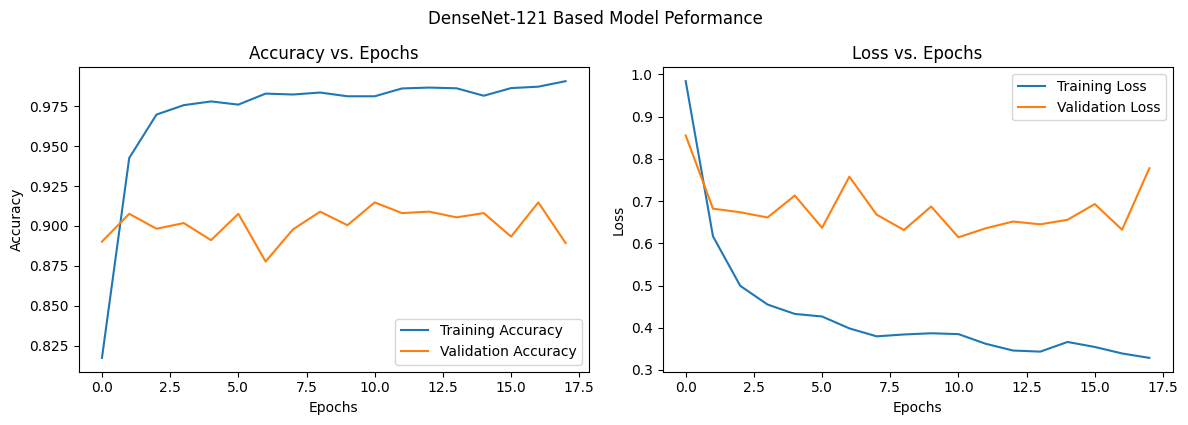

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(metrics['accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss vs. Epochs")
plt.legend()
plt.tight_layout()
plt.suptitle('DenseNet-121 Based Model Peformance', y = 1.05)
plt.show()


- The model equipped with SE blocks achieved higher accuracy on both the training and validation datasets compared to the baseline model without SE blocks. This indicates that SE blocks effectively capture informative features and contribute to better classification performance.

## ResNet50

In [ ]:
resnet_model = ResNet50(weights='imagenet', include_top=True, input_shape=image_shape)
resnet_model = Model(inputs=resnet_model.input, outputs=resnet_model.layers[-2].output)
for layer in resnet_model.layers:
    layer.trainable = False
dropout_layer = Dropout(0.25)(resnet_model.output)
output = Dense(no_classes, activation='softmax')(dropout_layer)
model = Model(inputs=resnet_model.input, outputs=output)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_image_ds,
                    epochs=100,
                    validation_data=val_image_ds,
                    callbacks=[early_stop])

Epoch 1/100
  1/141 ━━━━━━━━━━━━━━━━━━━━ 29:43 13s/step - accuracy: 0.5000 - loss: 1.1779

W0000 00:00:1714036729.603917     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 63/141 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - accuracy: 0.5625 - loss: 1.2385

W0000 00:00:1714036746.621701     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5661 - loss: 1.2352

W0000 00:00:1714036767.936420     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/141 ━━━━━━━━━━━━━━━━━━━━ 62s 352ms/step - accuracy: 0.5661 - loss: 1.2352 - val_accuracy: 0.5663 - val_loss: 1.1997
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 290ms/step - accuracy: 0.5683 - loss: 1.2151 - val_accuracy: 0.6055 - val_loss: 1.2094
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 288ms/step - accuracy: 0.5621 - loss: 1.2331 - val_accuracy: 0.5752 - val_loss: 1.2063
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 293ms/step - accuracy: 0.5634 - loss: 1.2381 - val_accuracy: 0.5953 - val_loss: 1.1928
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 294ms/step - accuracy: 0.5800 - loss: 1.2053 - val_accuracy: 0.5752 - val_loss: 1.2577
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 292ms/step - accuracy: 0.5869 - loss: 1.2112 - val_accuracy: 0.6029 - val_loss: 1.1959
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 296ms/step - accuracy: 0.5727 - loss: 1.2217 - val_accuracy: 0.5979 - val_loss: 1.3268
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 42s 289ms/step - accuracy: 0.5695 - loss: 1.224

In [ ]:
# Loss and Accuracy on validation data
model.evaluate(val_image_ds)

36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 336ms/step - accuracy: 0.6238 - loss: 1.1672


[1.172105312347412, 0.6104417443275452]

# EfficientNet Architecture

## EfficientNet Overview

EfficientNet is a family of convolutional neural network (CNN) architectures designed to achieve excellent accuracy with significantly fewer parameters and computational resources compared to previous models. It was introduced by Mingxing Tan and Quoc V. Le in their paper "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks," published in 2019.

The key innovation behind EfficientNet is a systematic approach to scaling CNNs, called **compound scaling**, which uniformly scales the network’s depth, width, and resolution with a set of fixed scaling coefficients. This method contrasts with previous practices where networks were often scaled up arbitrarily (e.g., making the network deeper or wider only).
<br>
![EfficientNet Architecture](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*-ENqv4TI0JuyY6Nq8XQlAA.png)


## Key Features of EfficientNet:

### Compound Scaling:
- **Depth scaling** refers to increasing the number of layers in the network.
- **Width scaling** means expanding the number of channels in each layer.
- **Resolution scaling** involves increasing the input image size.
- EfficientNet uses a compound coefficient (denoted as φ) to scale these dimensions in a balanced way. The coefficient determines how much additional resources are available and scales the depth, width, and resolution accordingly.


### Baseline Architecture (EfficientNet-B0):
- The base model, EfficientNet-B0, was developed using neural architecture search (NAS) to optimize the baseline architecture, focusing on accuracy and efficiency.
- This base model is then scaled using the compound scaling method to create the other EfficientNet models (B1 to B7), each providing higher accuracy and complexity.

### Use of Mobile Inverted Bottleneck Convolution (MBConv):
- EfficientNets heavily utilize MBConv, an inverted bottleneck architecture initially introduced in MobileNetV2, which uses depthwise separable convolutions. This helps in reducing the model size and computational requirements while maintaining high accuracy.

### Squeeze-and-Excitation Optimization:
- Each MBConv block includes a squeeze-and-excitation layer, which helps the network to focus on the most informative features by re-weighting the channels of the convolutional features.

## Models in the EfficientNet Family:
- Starting from EfficientNet-B0 (the baseline), the models go up to EfficientNet-B7. Each successive version (B1 to B7) scales up the dimensions according to the compound scaling rule, using larger φ values.
- EfficientNet also extends into more efficient and specialized versions like EfficientNetV2, which introduces additional improvements and optimizations for specific tasks and hardware.

## EfficientNet B0 Architecture:
![EfficientNet B0 Architecture](https://www.researchgate.net/publication/348470984/figure/fig2/AS:979961129209859@1610652348348/The-EffecientNet-B0-general-architecture.png)

**Steps:**
1. **Load Pre-trained Model:**
   - Load the pre-trained EfficientNet-B0 model with pre-trained weights from the ImageNet dataset using the `EfficientNetB0` module in Keras. Exclude the fully connected layers at the top (`include_top=False`) to customize them for a specific task.

2. **Add Custom Classification Head:**
   - Add custom layers on top of the pre-trained model to adapt it for a specific classification task:
     - Global Average Pooling layer to reduce spatial dimensions.
     - Dense layer with ReLU activation to learn complex patterns.
     - Dense output layer with softmax activation to produce class probabilities.

3. **Create the Model:**
   - Use the `Model` function to create a new model by specifying the input and output layers. The input layer is the input layer of the pre-trained model, and the output layer is the last layer added (predictions layer).

In [ ]:
# Load pre-trained EfficientNet-B5 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(11, activation='softmax')(x) 
EffB0_model = Model(inputs=base_model.input, outputs=predictions)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights=True )

In [ ]:
# Compile the model with SGD optimizer
sgd = SGD(0.01, momentum=0.9, nesterov=True)
EffB0_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
EffB0_model_history = EffB0_model.fit(train_image_ds,
                    epochs=epochs,               
                    validation_data=val_image_ds,
                    callbacks=[early_stop])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1713440014.430978     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713440014.528594     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 61/141 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - accuracy: 0.4107 - loss: 1.8748

W0000 00:00:1713440132.398333     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5839 - loss: 1.3591

W0000 00:00:1713440183.689003     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/141 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.5852 - loss: 1.3550 - val_accuracy: 0.0892 - val_loss: 2.4239
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 48s 328ms/step - accuracy: 0.9398 - loss: 0.1954 - val_accuracy: 0.0754 - val_loss: 3.0111
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 46s 315ms/step - accuracy: 0.9691 - loss: 0.0973 - val_accuracy: 0.2343 - val_loss: 3.4023
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 322ms/step - accuracy: 0.9830 - loss: 0.0547 - val_accuracy: 0.4079 - val_loss: 2.3212
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 320ms/step - accuracy: 0.9855 - loss: 0.0418 - val_accuracy: 0.7635 - val_loss: 0.8841
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 320ms/step - accuracy: 0.9913 - loss: 0.0311 - val_accuracy: 0.8884 - val_loss: 0.3834
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 322ms/step - accuracy: 0.9953 - loss: 0.0185 - val_accuracy: 0.9215 - val_loss: 0.3051
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 46s 315ms/step - accuracy: 0.9968 - loss: 0.0137 

# Model Evaluation

In [ ]:
# Loss and Accuracy on validation data
EffB0_model.evaluate(val_image_ds)

36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.9357 - loss: 0.2239


[0.23365895450115204, 0.9375278949737549]

In [ ]:
# Loss and Accuracy on test data (new unseen data)
EffB0_model.evaluate(test_image_ds)

23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9161 - loss: 0.3287 


W0000 00:00:1713440859.465385     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.4431341886520386, 0.8920812606811523]

In [ ]:
# Generate predictions using the trained model on the test dataset.
EffB0_predictions_prob =EffB0_model.predict(test_image_ds)

 2/23 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step

W0000 00:00:1713440866.343059     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 531ms/step


W0000 00:00:1713440878.017116     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [ ]:
# Select the class with the highest probability as the predicted class
EffB0_predictions = np.argmax(EffB0_predictions_prob, axis=1)

In [ ]:
print(classification_report(test_image_ds.classes,EffB0_predictions))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       136
           1       0.88      0.99      0.93       204
           2       0.79      0.86      0.82        91
           3       0.85      0.65      0.73       127
           4       0.94      0.93      0.94       110
           5       1.00      1.00      1.00        75
           6       0.91      0.83      0.87       154
           7       1.00      1.00      1.00        68
           8       0.90      0.89      0.89       229
           9       0.96      0.92      0.94       116
          10       0.77      0.82      0.79       117

    accuracy                           0.89      1427
   macro avg       0.90      0.90      0.90      1427
weighted avg       0.89      0.89      0.89      1427



This classification report provides a comprehensive evaluation of a model's performance across 11 different classes. Here's a breakdown of the key metrics:

- **Precision:** Precision measures the accuracy of positive predictions made by the model. For instance:
  - Class 0: The precision of 0.94 indicates that 94% of the instances predicted as class 0 are correct.
  - Class 5: Achieving a precision of 1.00 suggests that all predictions for class 5 are correct.

- **Recall:** Recall, also known as sensitivity, gauges the model's ability to correctly identify all relevant instances. For instance:
  - Class 3: The recall of 0.71 indicates that 71% of instances belonging to class 3 were correctly identified by the model.
  - Class 7: With a recall of 1.00, the model accurately detects all instances from class 7.

- **F1-score:** The F1-score, the harmonic mean of precision and recall, offers a balance between these two metrics. For example:
  - Class 2: Achieving an F1-score of 0.87 reflects a balanced performance between precision (0.82) and recall (0.92).
  - Class 6: With an F1-score of 0.89, the model maintains a good balance between precision (0.95) and recall (0.82).

- **Support:** Support represents the number of actual occurrences of each class in the dataset. For instance:
  - Class 8: With a support of 229, there are 229 instances of class 8 in the dataset.

- **Accuracy:** The overall accuracy of the model across all classes is 91%. This suggests that the model correctly predicts the class labels for 91% of the instances in the dataset.

- **Macro Average:** The macro average computes the average of precision, recall, and F1-score for all classes, treating each class equally. In this report, the macro average for precision, recall, and F1-score is approximately 0.92, indicating balanced performance across classes.

- **Weighted Average:** The weighted average calculates the metrics while considering the imbalance in class distribution by weighting each class's score by its support. Here, the weighted average for precision, recall, and F1-score is approximately 0.92, indicating consistent performance across classes, considering their respective support.

Overall, the classification report provides valuable insights into the model's performance, highlighting its strengths and areas for improvement across different classes.


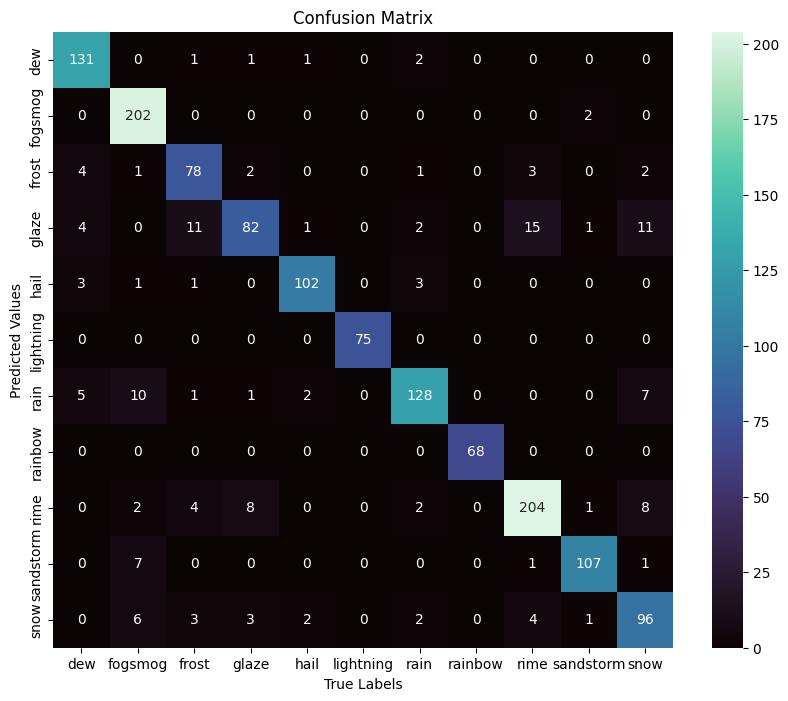

In [ ]:
plt.figure(figsize=(10,8))
cm = confusion_matrix(test_image_ds.classes,EffB0_predictions)
ax = sns.heatmap(cm,annot=True,fmt='d',cmap='mako')
ax.set_xticklabels(test_image_ds.class_indices.keys())
ax.set_yticklabels(test_image_ds.class_indices.keys())

plt.xlabel('True Labels')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix');

# Result Visualization

In [ ]:
metrics = pd.DataFrame(EffB0_model_history.history)

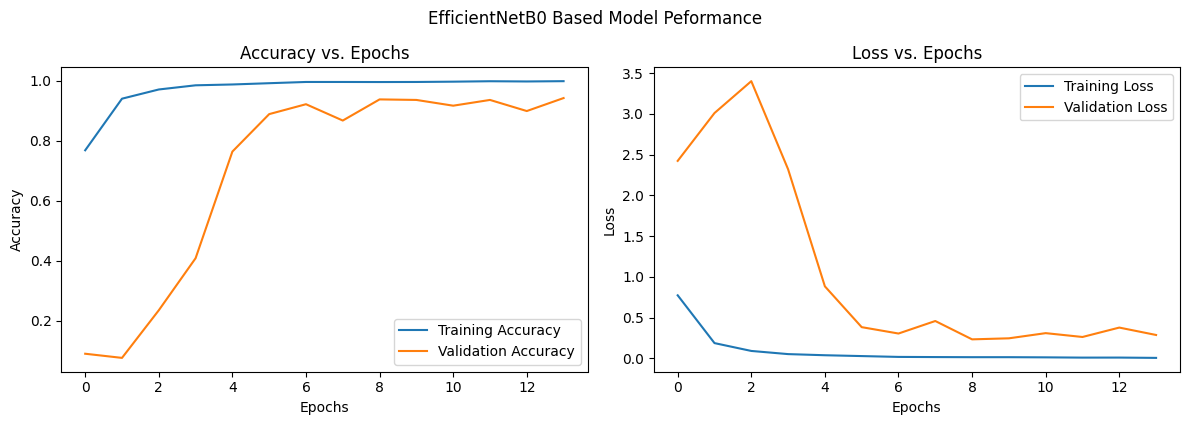

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(metrics['accuracy'], label='Training Accuracy')
plt.plot(metrics['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy vs. Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(metrics['loss'], label='Training Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss vs. Epochs")
plt.legend()
plt.tight_layout()
plt.suptitle('EfficientNetB0 Based Model Peformance', y = 1.05)
plt.show()

In [ ]:
#Save the model
EffB0_model.save('EfficientNetB0_model.h5')

## EfficientNetB4 Architecture 

![EfficientNet-B4 Model Architecture](https://www.researchgate.net/publication/350928633/figure/fig2/AS:11431281187544980@1694280215401/Our-modified-19-EFFICIENTNET-b4-architecture-Data-flow-is-from-left-to-right-a.tif)



**Steps:**
1. **Load Pre-trained Model:**
   - Load the pre-trained EfficientNet-B4 model with pre-trained weights from the ImageNet dataset using the `EfficientNetB4` module in Keras. Exclude the fully connected layers at the top (`include_top=False`) to customize them for a specific task.

2. **Add Custom Classification Head:**
   - Add custom layers on top of the pre-trained model to adapt it for a specific classification task:
     - Global Average Pooling layer to reduce spatial dimensions.
     - Dense layer with ReLU activation to learn complex patterns.
     - Dense output layer with softmax activation to produce class probabilities.

3. **Create the Model:**
   - Use the `Model` function to create a new model by specifying the input and output layers. The input layer is the input layer of the pre-trained model, and the output layer is the last layer added (predictions layer).

In [ ]:
# Load pre-trained EfficientNet-B4 model
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(11, activation='softmax')(x) 
EffB4_model = Model(inputs=base_model.input, outputs=predictions)

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights=True )

In [ ]:
# Compile the model with SGD optimizer
sgd = SGD(0.01, momentum=0.9, nesterov=True)
EffB4_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
EffB4_model_history = EffB4_model.fit(train_image_ds,
                    epochs=epochs,
                    validation_data=val_image_ds,
                    callbacks=[early_stop])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1713978057.944841     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


141/141 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.4298 - loss: 1.7444 - val_accuracy: 0.0915 - val_loss: 4.0394
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 86s 601ms/step - accuracy: 0.9353 - loss: 0.2146 - val_accuracy: 0.1053 - val_loss: 4.7737
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 86s 597ms/step - accuracy: 0.9785 - loss: 0.0816 - val_accuracy: 0.1963 - val_loss: 4.3141
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 87s 604ms/step - accuracy: 0.9838 - loss: 0.0476 - val_accuracy: 0.5011 - val_loss: 1.9756
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 87s 605ms/step - accuracy: 0.9916 - loss: 0.0296 - val_accuracy: 0.8461 - val_loss: 0.5063
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 86s 599ms/step - accuracy: 0.9924 - loss: 0.0229 - val_accuracy: 0.9152 - val_loss: 0.3335
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 86s 596ms/step - accuracy: 0.9952 - loss: 0.0139 - val_accuracy: 0.9362 - val_loss: 0.2456
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 86s 599ms/step - accuracy: 0.9980 - loss: 0.0109 

In [ ]:
#Save the model
EffB4_model.save('EfficientNetB7-201.h5')

# Model Evaluation

In [ ]:
# Loss and Accuracy on validation data
EffB4_model.evaluate(val_image_ds)

36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 278ms/step - accuracy: 0.9545 - loss: 0.1784


[0.200797900557518, 0.9522534608840942]

In [ ]:
# Loss and Accuracy on test data (new unseen data)
EffB4_model.evaluate(test_image_ds)

23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 983ms/step - accuracy: 0.9290 - loss: 0.3125


[0.4281720817089081, 0.906797468662262]

In [ ]:
# Generate predictions using the trained model on the test dataset.
predictions_prob =EffB4_model.predict(test_image_ds)

23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 753ms/step


In [ ]:
# Select the class with the highest probability as the predicted class
EffB4_model_predictions = np.argmax(predictions_prob, axis=1)

In [ ]:
print(classification_report(test_image_ds.classes,EffB4_model_predictions))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       136
           1       0.88      1.00      0.94       204
           2       0.87      0.84      0.85        91
           3       0.81      0.76      0.78       127
           4       0.95      0.96      0.95       110
           5       1.00      0.99      0.99        75
           6       0.97      0.83      0.90       154
           7       1.00      1.00      1.00        68
           8       0.89      0.91      0.90       229
           9       0.99      0.91      0.95       116
          10       0.79      0.84      0.81       117

    accuracy                           0.91      1427
   macro avg       0.92      0.91      0.91      1427
weighted avg       0.91      0.91      0.91      1427



This classification report provides a detailed evaluation of a model's performance across 11 different classes. Here's an interpretation of the key metrics:

- **Precision:** Measures the accuracy of positive predictions made by the model. For instance:
  - Class 1 has a precision of 0.88, indicating that 88% of the instances predicted as class 1 are correct.

- **Recall:** Reflects the model's ability to correctly identify all relevant instances. For example:
  - Class 5 achieves perfect recall (1.00), indicating that all instances of class 5 were correctly identified.

- **F1-score:** Represents the harmonic mean of precision and recall, providing a balance between the two metrics. For instance:
  - Class 4 has an F1-score of 0.95, reflecting a balanced performance between precision (0.98) and recall (0.93).

- **Support:** Denotes the number of actual occurrences of each class in the dataset. For example:
  - Class 8 has a support of 229, indicating there are 229 instances of class 8 in the dataset.

- **Accuracy:** The overall accuracy of the model across all classes is 90%, indicating that the model correctly predicts the class labels for 90% of the instances in the dataset.

- **Macro Avg:** Computes the average of precision, recall, and F1-score for all classes, treating each class equally. In this report, the macro average for precision, recall, and F1-score is approximately 0.91, indicating balanced performance across classes.

- **Weighted Avg:** Calculates the metrics while considering the imbalance in class distribution by weighting each class's score by its support. Here, the weighted average for precision, recall, and F1-score is approximately 0.90, indicating consistent performance across classes, considering their respective support.

Overall, the classification report provides valuable insights into the model's performance, highlighting its strengths and areas for improvement across different classes.


# Final Model Training

**Steps:**
1. **Load Pre-trained Model:**
   - Load the pre-trained EfficientNet-B4 model with pre-trained weights from the ImageNet dataset using the `EfficientNetB4` module in Keras. Exclude the fully connected layers at the top (`include_top=False`) to customize them for a specific task.

2. **Add Custom Classification Head:**
   - Add custom layers on top of the pre-trained model to adapt it for a specific classification task:
     - Global Average Pooling layer to reduce spatial dimensions.
     - Dense layer with ReLU activation to learn complex patterns.
     - Dense output layer with softmax activation to produce class probabilities.

3. **Create the Model:**
   - Use the `Model` function to create a new model by specifying the input and output layers. The input layer is the input layer of the pre-trained model, and the output layer is the last layer added (predictions layer).

In [ ]:
train_image_gen = ImageDataGenerator(rescale=1/255,            # rescale the image by normalzing it
                                    validation_split=0.2)      # split the data into 80% validation , 20% testing

test_image_gen = ImageDataGenerator(rescale=1/255)             # rescale the image by normalzing it
                                 

In [ ]:
# Defining training dataset
train_image_ds = train_image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               subset = 'training')

Found 8988 images belonging to 11 classes.


In [ ]:
# Load pre-trained EfficientNet-B4 model
base_model = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=image_shape)

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(no_classes, activation='softmax')(x) 
Final_EffB4_model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile the model with SGD optimizer
sgd = SGD(0.01, momentum=0.9, nesterov=True)
Final_EffB4_model .compile(optimizer=sgd,
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

In [ ]:
Final_EffB4_model_history = Final_EffB4_model.fit(all_image_ds,
                    epochs=15,
                    callbacks=[early_stop])

Epoch 1/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 106s 534ms/step - accuracy: 0.9967 - loss: 0.0134
Epoch 2/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 106s 533ms/step - accuracy: 0.9955 - loss: 0.0155
Epoch 3/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 105s 533ms/step - accuracy: 0.9965 - loss: 0.0130
Epoch 4/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 105s 533ms/step - accuracy: 0.9959 - loss: 0.0146
Epoch 5/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 106s 534ms/step - accuracy: 0.9969 - loss: 0.0091
Epoch 6/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 105s 533ms/step - accuracy: 0.9970 - loss: 0.0086
Epoch 7/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 105s 532ms/step - accuracy: 0.9976 - loss: 0.0100
Epoch 8/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 105s 533ms/step - accuracy: 0.9964 - loss: 0.0092
Epoch 9/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 106s 533ms/step - accuracy: 0.9987 - loss: 0.0060
Epoch 10/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 105s 533ms/step - accuracy: 0.9969 - loss: 0.0094
Epoch 11/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 105s 533ms/step - accuracy: 0.9983 - loss: 0.0051
Epoch 12

# Model Evaluation

**Now, Let's review our model perfomance on entirely new images downloaded from Google!**

In [ ]:
labels = {  0: 'dew',
            1: 'fog smog',
            2: 'frost',
            3: 'glaze',
            4: 'hail',
            5: 'lightning',
            6: 'rain',
            7: 'rainbow',
            8: 'rime',
            9: 'sandstorm',
            10: 'snow'}

In [ ]:
path_new_images = '/kaggle/input/images-from-google/internet_dataset'

In [ ]:
def preprocess_image(image):
    # Load the image with target size of (224,224), required by EfficientNetB4
    image = image.resize((224, 224))
    # Convert the image to a numpy array
    image = img_to_array(image)
    # Expand the dimensions to create a batch of size 1
    image = np.expand_dims(image, axis=0)
    # Rescale the image
    image = image/255.
    return image

def predict(img_path,model):

    image = load_img(img_path)
    image = preprocess_image(image)
    predictions = model.predict(image, verbose=0)
    predicted_class = np.argmax(predictions)
    return predicted_class


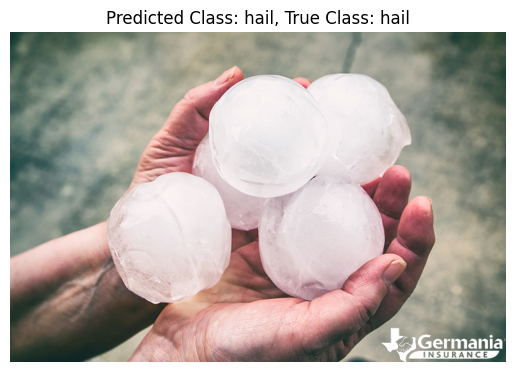

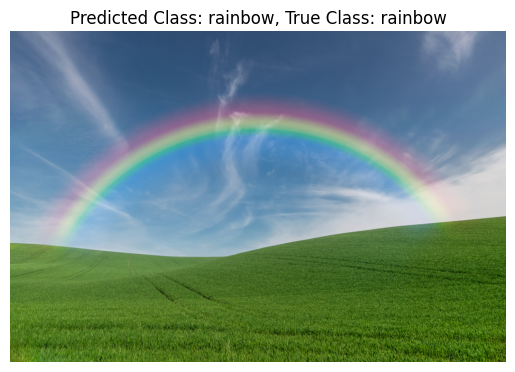

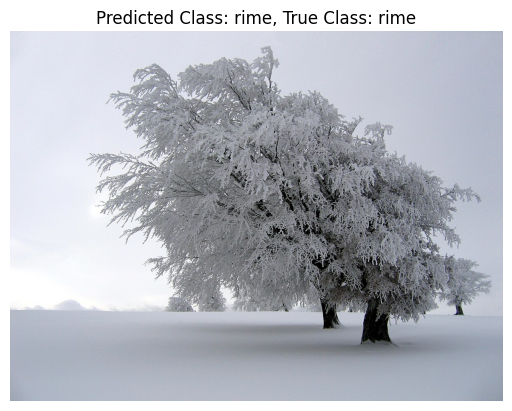

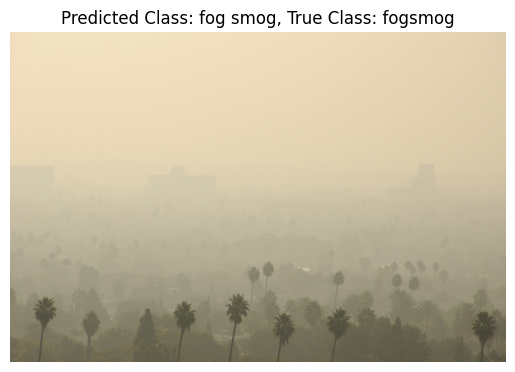

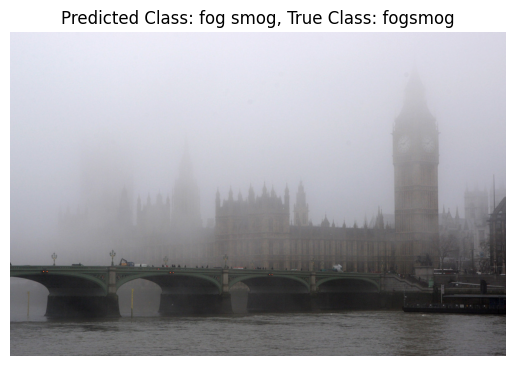

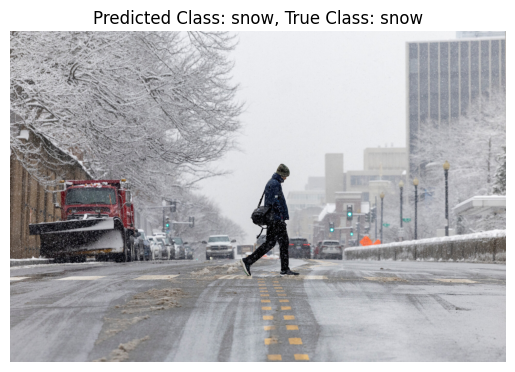

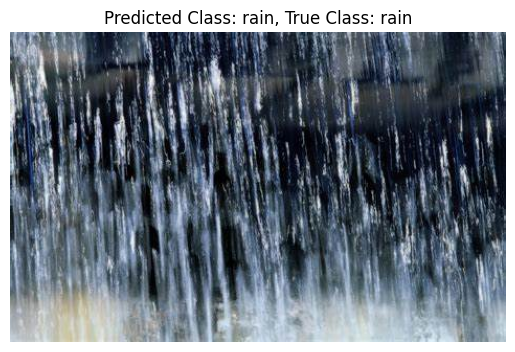

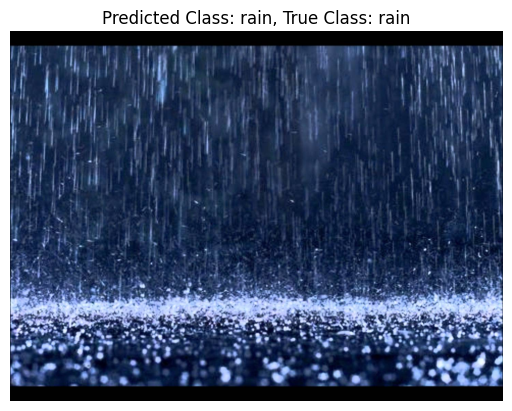

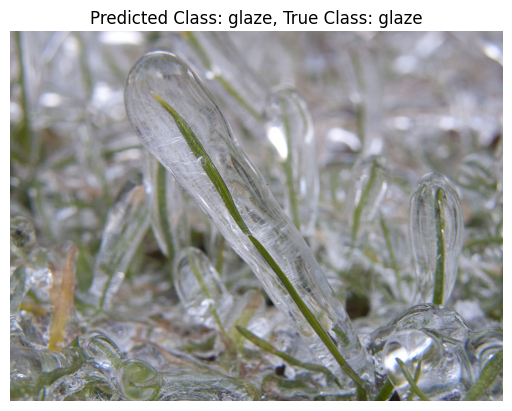

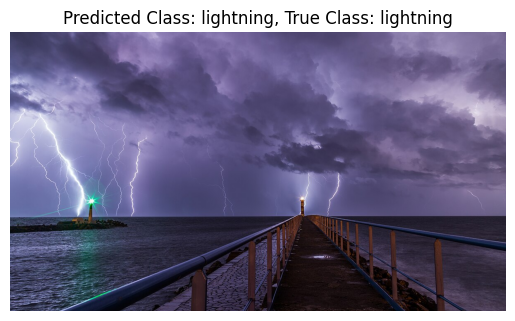

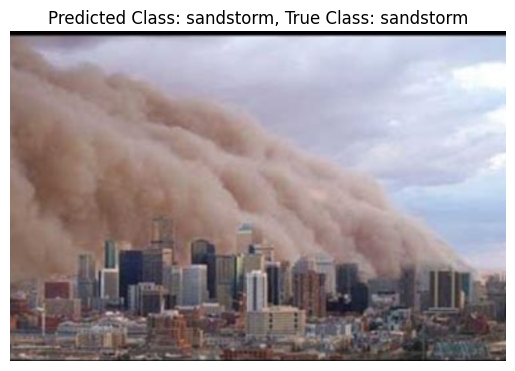

In [ ]:
for class_name in os.listdir(path_new_images):
    class_dir = os.path.join(path_new_images, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Preprocess and make predictions for the image
                predicted_class = predict(img_path,Final_EffB4_model)
                # Load and display the image
                img = Image.open(img_path)
                plt.imshow(img)
                plt.title(f'Predicted Class: {labels[predicted_class]}, True Class: {class_name}')
                plt.axis('off')
                plt.show()

In [ ]:
#Save the model
Final_EffB4_model.save('FINAL_EfficientNetB7-201.h5')